In [1]:
# importing required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# dataset loading
df = pd.read_csv('portfolio_data.csv')

In [4]:
df.head(6)

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285
5,5/8/2013,258.679993,54.385727,112.800003,29.801428


# data cleaning

In [5]:
# Checking for missing values
print(df.isnull().sum())

Date    0
AMZN    0
DPZ     0
BTC     0
NFLX    0
dtype: int64


In [6]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1520 non-null   object 
 1   AMZN    1520 non-null   float64
 2   DPZ     1520 non-null   float64
 3   BTC     1520 non-null   float64
 4   NFLX    1520 non-null   float64
dtypes: float64(4), object(1)
memory usage: 59.5+ KB


In [8]:
# Converting the 'date' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
# Setting 'date' as the index
df.set_index('Date', inplace=True)

# Exploratory Data Analysis (EDA)

In [10]:
df.describe()

,AMZN,DPZ,BTC,NFLX
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,821.541810,146.771695,2421.465669,147.668273
std,518.442653,72.192287,3310.894199,107.641486
min,248.229996,51.190983,69.660004,29.464285
25%,364.360001,84.993593,340.904999,62.851071
50%,686.459992,127.168053,625.304993,104.000000
75%,1121.287536,202.454994,3874.912415,192.207496
max,2039.510010,298.635986,18972.320310,418.970001


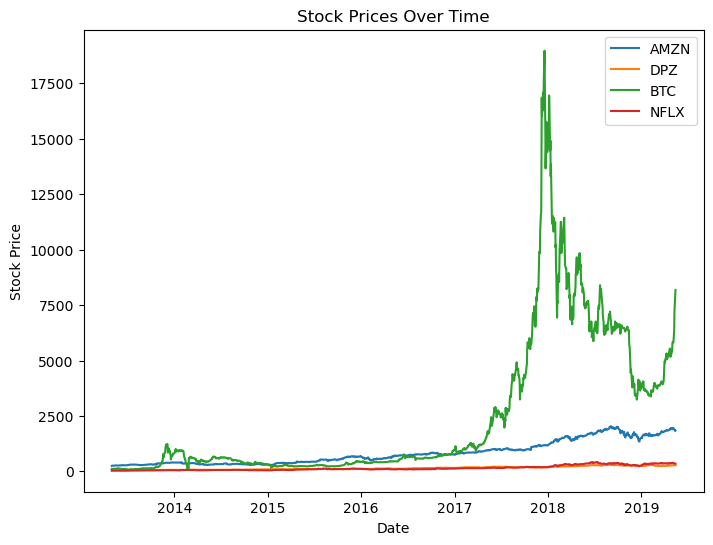

In [11]:
# Plotting the stock prices over time
plt.figure(figsize=(8, 6))
plt.plot(df['AMZN'], label='AMZN')
plt.plot(df['DPZ'], label='DPZ')
plt.plot(df['BTC'], label='BTC')
plt.plot(df['NFLX'], label='NFLX')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:
# Now, checking if the 'Date' column is set as the index
print(df.index)

DatetimeIndex(['2013-05-01', '2013-05-02', '2013-05-03', '2013-05-06',
               '2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10',
               '2013-05-13', '2013-05-14',
               ...
               '2019-05-01', '2019-05-02', '2019-05-03', '2019-05-06',
               '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10',
               '2019-05-13', '2019-05-14'],
              dtype='datetime64[ns]', name='Date', length=1520, freq=None)


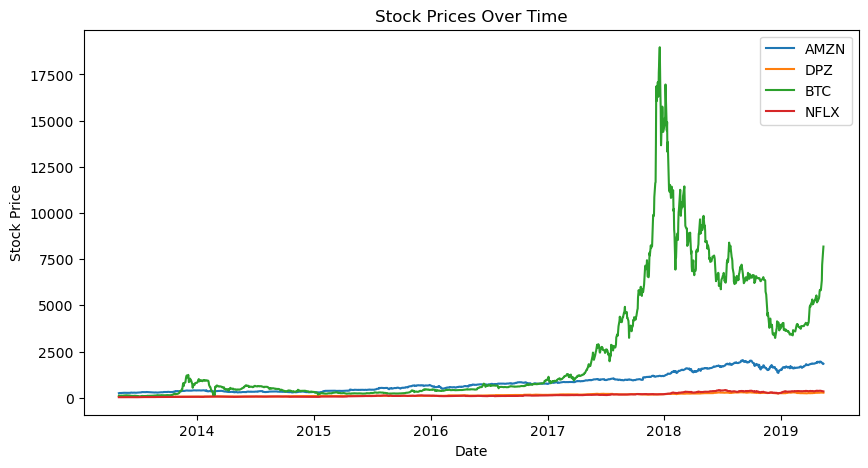

In [13]:
# Time Series Plot for Each Stock
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['AMZN'], label='AMZN')
plt.plot(df.index, df['DPZ'], label='DPZ')
plt.plot(df.index, df['BTC'], label='BTC')
plt.plot(df.index, df['NFLX'], label='NFLX')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

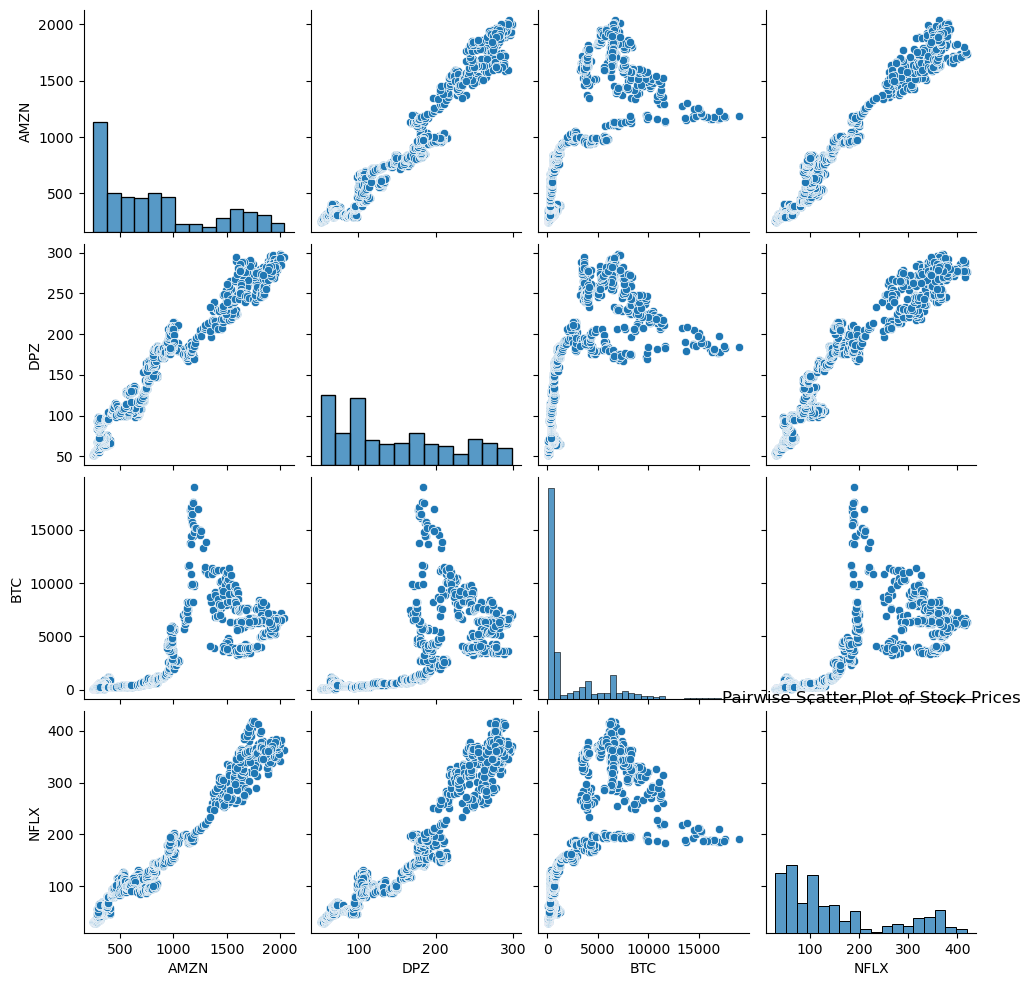

In [14]:
# Pairwise Scatter Plot
import seaborn as sns
sns.pairplot(df[['AMZN', 'DPZ', 'BTC', 'NFLX']])
plt.title('Pairwise Scatter Plot of Stock Prices')
plt.show()

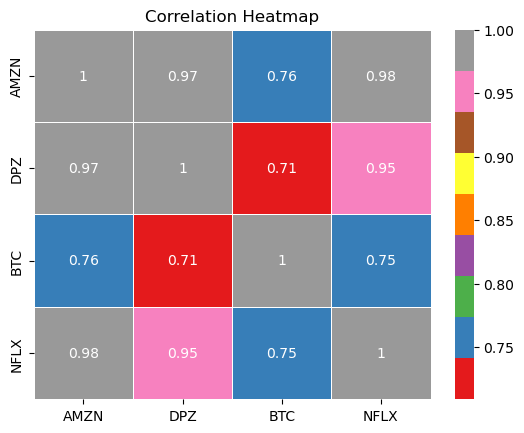

In [15]:
# Correlation Heatmap
corr_matrix = df[['AMZN', 'DPZ', 'BTC', 'NFLX']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Set1', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing

In [16]:
stock_column = 'AMZN'

In [17]:
# Calculation of the ratio of price differences
df['price_diff'] = df[stock_column].diff()
df['price_ratio'] = df['price_diff'] / df[stock_column].shift(1)

In [18]:
# Selection of relevant columns for modeling
data = df[['price_ratio']]

In [19]:
# Normalization of data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [20]:
# Converting the scaled data back to a DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=data.columns)

# Creating the sequences of past data to past 10 days
sequence_length = 10
sequences = []
for i in range(len(df_scaled) - sequence_length):
    sequences.append(df_scaled.iloc[i:i + sequence_length + 1].values)

In [21]:
# Converting the list of sequences to a NumPy array
sequences = np.array(sequences)

In [22]:
# Splitting data into features and target
X = sequences[:, :-1, :]
y = sequences[:, -1, 0]   # Predicting the 'price_ratio' column  

In [23]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Checking for NaN values in the training and testing sets
nan_indices_train = np.where(np.isnan(X_train))
nan_indices_test = np.where(np.isnan(X_test))
# Handling NaN values in X_train
for idx in zip(nan_indices_train[0], nan_indices_train[1], nan_indices_train[2]):
    X_train[idx[0], idx[1], idx[2]] = df_scaled.iloc[idx[0], idx[1]]

# Handling NaN values in X_test
for idx in zip(nan_indices_test[0], nan_indices_test[1], nan_indices_test[2]):
    X_test[idx[0], idx[1], idx[2]] = df_scaled.iloc[idx[0], idx[1]]

# Confirming that NaN values are resolved
if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
    raise ValueError("NaN values found in the training or testing data after handling. Please investigate and handle missing values appropriately.")

# LSTM model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Building the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mae')

In [28]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
history_lstm = model_lstm.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
38/38 [==============================] - 5s 23ms/step - loss: 0.2546 - val_loss: 0.0862
Epoch 2/30
38/38 [==============================] - 0s 10ms/step - loss: 0.0578 - val_loss: 0.0530
Epoch 3/30
38/38 [==============================] - 1s 23ms/step - loss: 0.0523 - val_loss: 0.0529
Epoch 4/30
38/38 [==============================] - 1s 15ms/step - loss: 0.0524 - val_loss: 0.0524
Epoch 5/30
38/38 [==============================] - 0s 11ms/step - loss: 0.0524 - val_loss: 0.0520
Epoch 6/30
38/38 [==============================] - 0s 10ms/step - loss: 0.0521 - val_loss: 0.0532
Epoch 7/30
38/38 [==============================] - 1s 14ms/step - loss: 0.0526 - val_loss: 0.0530
Epoch 8/30
38/38 [==============================] - 1s 15ms/step - loss: 0.0525 - val_loss: 0.0542
Epoch 9/30
38/38 [==============================] - 0s 12ms/step - loss: 0.0525 - val_loss: 0.0531
Epoch 10/30
38/38 [==============================] - 0s 11ms/step - loss: 0.0523 - val_loss: 0.0517
Epoch 11/

In [29]:
# Evaluating the LSTM model on the test set
loss_lstm = model_lstm.evaluate(X_test, y_test)
print(f'Mean Absolute Error for LSTM on Test Set: {loss_lstm}')

10/10 [==============================] - 0s 10ms/step - loss: 0.0513
Mean Absolute Error for LSTM on Test Set: 0.05130475014448166


In [30]:
# Making predictions on the test set using LSTM
predictions_lstm = model_lstm.predict(X_test)

10/10 [==============================] - 1s 5ms/step


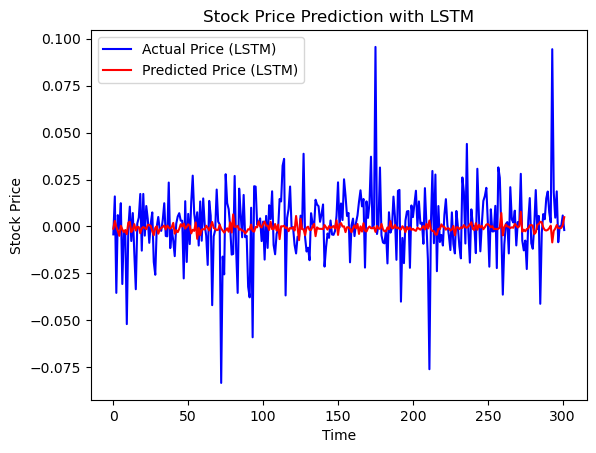

In [31]:
# Inverse transforming the predictions and actual values to the original scale for LSTM
predicted_prices_lstm = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), predictions_lstm.reshape(-1, 1))))
actual_prices_lstm = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1))))

# Visualizing the results for LSTM
plt.plot(actual_prices_lstm[:, 1], label='Actual Price (LSTM)', color='blue')
plt.plot(predicted_prices_lstm[:, 1], label='Predicted Price (LSTM)', color='red')
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#  RNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [33]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mae')  # Using Mean Absolute Error (MAE) instead of MSE

# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
38/38 [==============================] - 6s 30ms/step - loss: 0.1388 - val_loss: 0.0636
Epoch 2/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0545 - val_loss: 0.0538
Epoch 3/30
38/38 [==============================] - 0s 12ms/step - loss: 0.0530 - val_loss: 0.0533
Epoch 4/30
38/38 [==============================] - 0s 12ms/step - loss: 0.0533 - val_loss: 0.0540
Epoch 5/30
38/38 [==============================] - 0s 11ms/step - loss: 0.0535 - val_loss: 0.0530
Epoch 6/30
38/38 [==============================] - 1s 13ms/step - loss: 0.0532 - val_loss: 0.0528
Epoch 7/30
38/38 [==============================] - 0s 10ms/step - loss: 0.0533 - val_loss: 0.0542
Epoch 8/30
38/38 [==============================] - 0s 12ms/step - loss: 0.0533 - val_loss: 0.0539
Epoch 9/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0529 - val_loss: 0.0525
Epoch 10/30
38/38 [==============================] - 0s 12ms/step - loss: 0.0535 - val_loss: 0.0550
Epoch 11/

In [34]:
# Evaluation of the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on Test Set: {loss}')

10/10 [==============================] - 0s 5ms/step - loss: 0.0515
Mean Absolute Error on Test Set: 0.051464591175317764


In [35]:
# Making predictions on the test set
predictions = model.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [36]:
# Inverse transforming the predictions and actual values to its original scale
predicted_prices = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), predictions.reshape(-1, 1))))
actual_prices = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1))))

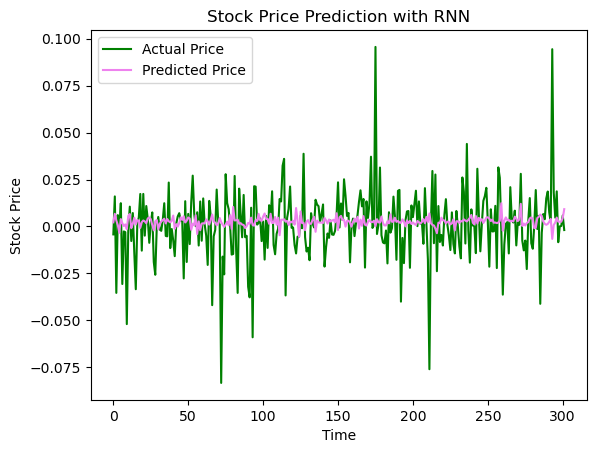

In [37]:
# Visualization of the results
plt.plot(actual_prices[:, 1], label='Actual Price', color='green')
plt.plot(predicted_prices[:, 1], label='Predicted Price', color='violet')
plt.title('Stock Price Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Deep Neural Network (DNN)

In [38]:
from tensorflow.keras.layers import Dense

In [39]:
input_dim = X_train.shape[2]

In [40]:
# Creating a simple DNN model
model_dnn = Sequential()
model_dnn.add(Dense(units=50, activation='relu', input_dim=input_dim))
model_dnn.add(Dense(units=1))

model_dnn.compile(optimizer='adam', loss='mae')  # Using Mean Absolute Error (MAE)

In [41]:
# Training of the DNN model
model_dnn.fit(X_train[:, -1, :], y_train, epochs=30, batch_size=32, validation_data=(X_test[:, -1, :], y_test))

Epoch 1/30
38/38 [==============================] - 1s 10ms/step - loss: 0.3932 - val_loss: 0.2204
Epoch 2/30
38/38 [==============================] - 0s 4ms/step - loss: 0.1077 - val_loss: 0.0613
Epoch 3/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0550
Epoch 4/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0546 - val_loss: 0.0546
Epoch 5/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0544
Epoch 6/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.0542
Epoch 7/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0537 - val_loss: 0.0535
Epoch 8/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0537 - val_loss: 0.0533
Epoch 9/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0533 - val_loss: 0.0530
Epoch 10/30
38/38 [==============================] - 0s 4ms/step - loss: 0.0529 - val_loss: 0.0529
Epoch 11/30
38/38 

In [42]:
# Evaluation of the DNN model on the test set
loss_dnn = model_dnn.evaluate(X_test[:, -1, :], y_test)
print(f'Mean Absolute Error for DNN on Test Set: {loss_dnn}')

10/10 [==============================] - 0s 2ms/step - loss: 0.0504
Mean Absolute Error for DNN on Test Set: 0.05035547912120819


In [43]:
# Making predictions on the test set using DNN
predictions_dnn = model_dnn.predict(X_test[:, -1, :])

10/10 [==============================] - 0s 2ms/step


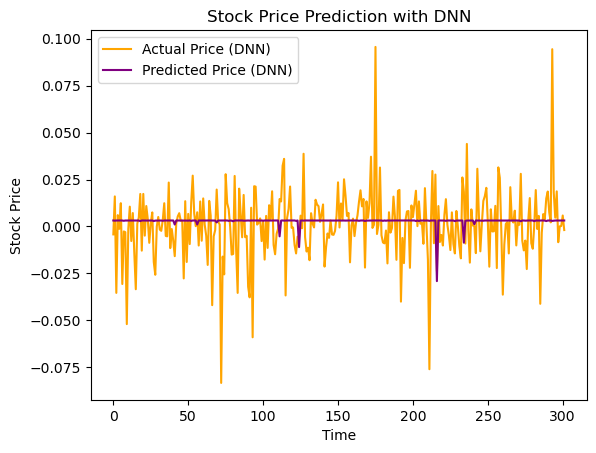

In [44]:
# Inverse transforming the predictions and actual values to the original scale for DNN
predicted_prices_dnn = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), predictions_dnn.reshape(-1, 1))))
actual_prices_dnn = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1))))

# Ploting the results for DNN
plt.plot(actual_prices_dnn[:, 1], label='Actual Price (DNN)', color='orange')
plt.plot(predicted_prices_dnn[:, 1], label='Predicted Price (DNN)', color='purple')
plt.title('Stock Price Prediction with DNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

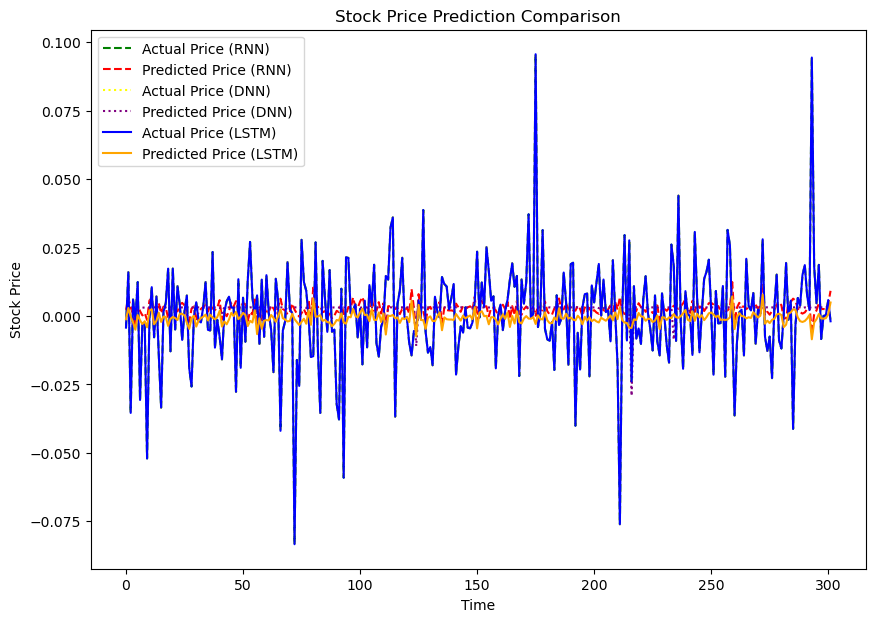

In [45]:
# Plotting the results for all three models
plt.figure(figsize=(10, 7))

# RNN
plt.plot(actual_prices[:, 1], label='Actual Price (RNN)', color='green', linestyle='dashed')
plt.plot(predicted_prices[:, 1], label='Predicted Price (RNN)', color='red', linestyle='dashed')

# DNN
plt.plot(actual_prices_dnn[:, 1], label='Actual Price (DNN)', color='yellow', linestyle='dotted')
plt.plot(predicted_prices_dnn[:, 1], label='Predicted Price (DNN)', color='purple', linestyle='dotted')

# LSTM
plt.plot(actual_prices_lstm[:, 1], label='Actual Price (LSTM)', color='blue')
plt.plot(predicted_prices_lstm[:, 1], label='Predicted Price (LSTM)', color='orange')

plt.title('Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
# reshaping the features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [54]:
# Creating and training the linear regression model
model_linear = LinearRegression()
model_linear.fit(X_train_flat, y_train)

LinearRegression()

In [57]:
# Making predictions on the test set
y_pred_linear = model_linear.predict(X_test_flat)

# Evaluation of the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f'Mean Squared Error (Linear Regression): {mse_linear}')

Mean Squared Error (Linear Regression): 0.005459623952194412


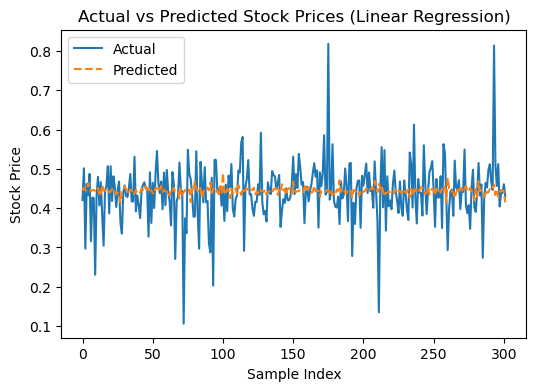

In [59]:
# Plotting actual vs predicted values
plt.figure(figsize=(6, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_linear, label='Predicted', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices (Linear Regression)')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()